In [12]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import linregress

#Deterministic System Stuff

def dynamical_system(t, z, r_ss):
    x, r = z
    l = 0.1
    dxdt = (1 + 50*x**2)/(1+x**2) - (r + 10)*x
    drdt = r_ss - r
    return [dxdt, drdt]

def simulate_system(t_span, t_eval, initial_conditions, r_ss=3.853264):
    """
    Simulate the dynamical system over the given time span with specified initial conditions.

    Parameters:
        t_span (tuple): Start and end times for the simulation.
        t_eval (array): Time points to evaluate the solution.
        initial_conditions (list of lists): Initial conditions for the state variables.
        l (float): Parameter controlling the relaxation rate of r.

    Returns:
        list of OdeResult: The solution for each initial condition.
    """
    solutions = []
    for z0 in initial_conditions:
        sol = solve_ivp(lambda t, z: dynamical_system(t, z, r_ss), t_span, z0, t_eval=t_eval, method='Radau')
        solutions.append(sol)
    return solutions

def plot_phase(solutions, initial_conditions):
    """
    Plot the solutions of the dynamical system in the phase plane.

    Parameters:
        solutions (list of OdeResult): The solutions to plot.
        initial_conditions (list of lists): Initial conditions corresponding to the solutions.
    """
    plt.figure(figsize=(8, 6))
    for sol, z0 in zip(solutions, initial_conditions):
        plt.plot(sol.y[1], sol.y[0], label=f'IC: {z0}')

    # Add fixed points and axes
    plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
    plt.axvline(0, color='black', linewidth=0.8, linestyle='--')

    # Label the plot
    plt.title('2D Dynamical System Trajectories')
    plt.xlabel('TEV')
    plt.ylabel('T7')
    plt.grid()
    plt.show()

def plot_time(solutions, t_eval, initial_conditions):
    """
    Plot the time series of x and r against time.

    Parameters:
        solutions (list of OdeResult): The solutions to plot.
        t_eval (array): Time points at which the solution was evaluated.
        initial_conditions (list of lists): Initial conditions corresponding to the solutions.
    """
    plt.figure(figsize=(10, 6))
    for sol, z0 in zip(solutions, initial_conditions):
        plt.plot(t_eval, sol.y[0], label=f'x')
        plt.plot(t_eval, sol.y[1], label=f'r', linestyle='--')
    
    # Label the plot
    plt.title('Time Series of T7 and TEV')
    plt.xlabel('Time')
    plt.ylabel('State Variables')
    plt.legend()
    plt.grid()
    plt.show()

def plot_time_log(solutions, t_eval, initial_conditions):
    """
    Plot the time series of x and r against time with a logarithmic scale for time.

    Parameters:
        solutions (list of OdeResult): The solutions to plot.
        t_eval (array): Time points at which the solution was evaluated.
        initial_conditions (list of lists): Initial conditions corresponding to the solutions.
    """
    plt.figure(figsize=(10, 6))
    for sol, z0 in zip(solutions, initial_conditions):
        plt.plot(t_eval, sol.y[0], label=f'T7 (IC: {z0})')
        plt.plot(t_eval, sol.y[1], label=f'TEV (IC: {z0})', linestyle='--')
    
    # Set logarithmic scale for time
    plt.xscale('log')
    
    # Label the plot
    plt.title('Time Series of T7 and TEV (Log Time Scale)')
    plt.xlabel('Time (log scale)')
    plt.ylabel('State Variables')
    plt.legend()
    plt.grid()
    plt.show()


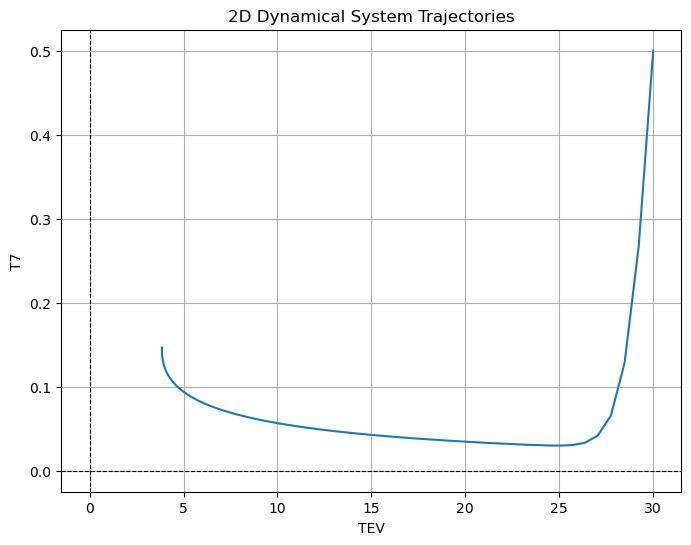

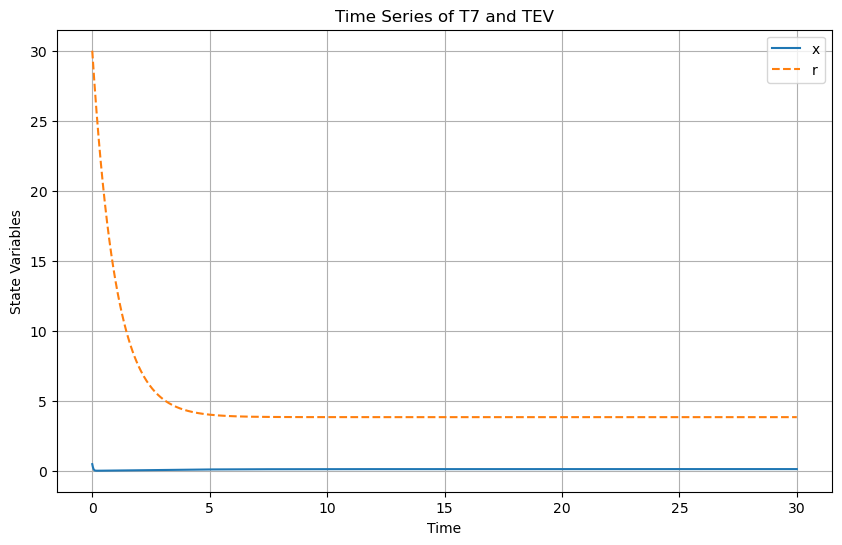

In [13]:
#Simulate with self organization to critical point
if __name__ == "__main__":
    # Time span and evaluation points
    t_span = (0, 30)
    t_eval = np.linspace(*t_span, 1000)

    # Initial conditions
    initial_conditions = [[0.5, 30]]

    # Simulate the system
    solutions = simulate_system(t_span, t_eval, initial_conditions)

    # Plot the solutions
    plot_phase(solutions, initial_conditions)
    plot_time(solutions, t_eval, initial_conditions)

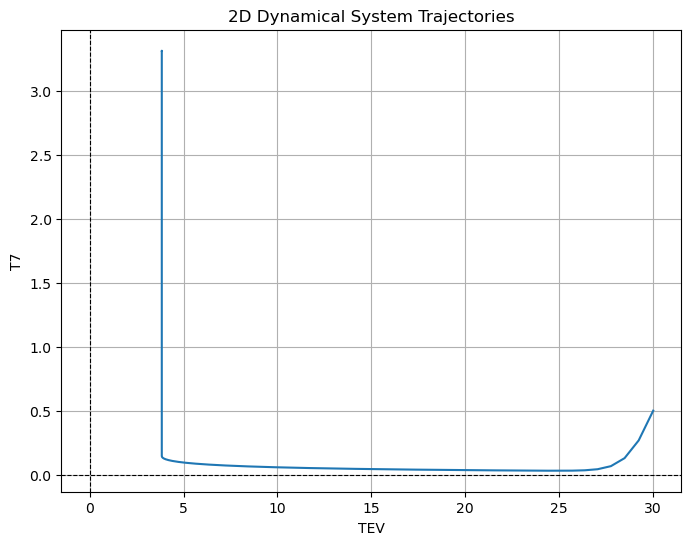

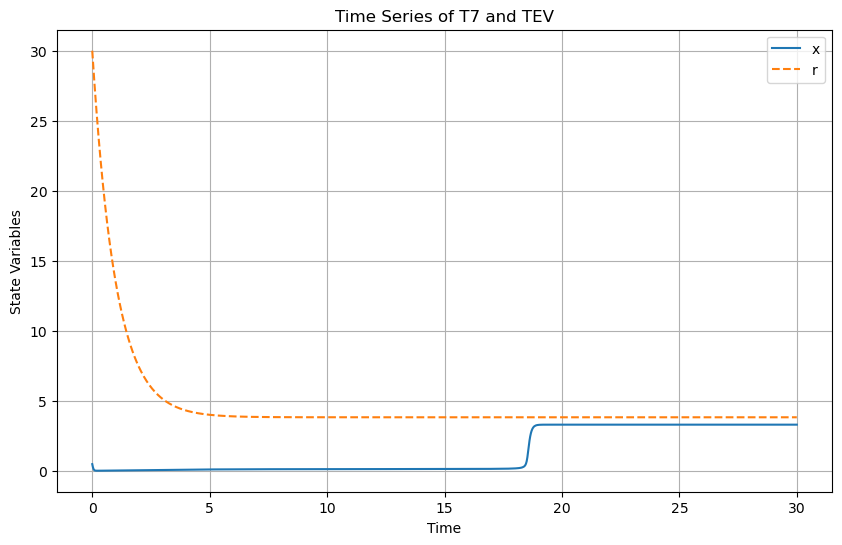

In [14]:
#Simulate with self organization to just past critical point
if __name__ == "__main__":
    # Time span and evaluation points
    t_span = (0, 30)
    t_eval = np.linspace(*t_span, 1000)

    # Initial conditions
    initial_conditions = [[0.5, 30.0]]

    # Simulate the system
    solutions = simulate_system(t_span, t_eval, initial_conditions, r_ss=3.853264-0.01)

    # Plot the solutions
    plot_phase(solutions, initial_conditions)
    plot_time(solutions, t_eval, initial_conditions)

In [15]:
#Stochastic Model Stuff

# Define the Euler-Maruyama method
def euler_maruyama(tspan, initial_conditions, r_ss=3.853264):
    """
    Solves the SDE using the Euler-Maruyama method with variable r.

    t_span (tuple): Start and end times for the simulation.
    initial_conditions (list of lists): Initial conditions for the state variables.
    r_ss: steady-state value of r
    """
    T = tspan[1]
    dt = 0.01
    N = int(T / dt)  # Number of time steps
    X = np.zeros(N)
    r = np.zeros(N)
    X[0] = initial_conditions[0]
    r[0] = initial_conditions[1]
    t = np.linspace(0, T, N)


    # Generate random numbers for the Wiener process (Brownian motion)
    dW_X = np.random.normal(0, np.sqrt(dt), N-1)
    dW_r = np.random.normal(0,np.sqrt(dt), N-1)

    for i in range(1, N):
        # Euler-Maruyama update for X
        X[i] = X[i-1] + ((1 + 50*X[i-1]**2)/(1+X[i-1]**2) - (r[i-1] + 10)*X[i-1]) * dt + (np.sqrt((1 + 50*X[i-1]**2)/(1+X[i-1]**2)) - np.sqrt(r[i-1]*X[i-1]) - np.sqrt(10*X[i-1])) * dW_X[i-1]
        # Update r based on its own differential equation
        r[i] = r[i-1] + (r_ss - r[i-1]) * dt + (np.sqrt(r_ss)-np.sqrt(r[i-1])) * dW_r[i-1]
        X[i] = np.max([0,X[i]])
        r[i] = np.max([0,r[i]])

    return t, X, r


def plot_phase_stochastic(t,X,r):
    plt.figure(figsize=(10, 6))
    plt.plot(r, X)
    plt.title('Phase Space Trajectory')
    plt.xlabel('TEV')
    plt.ylabel('T7')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_time_stochastic(t,X,r):
    plt.figure(figsize=(10, 6))
    plt.plot(t, X, label='T7(t)', color='b')
    plt.plot(t, r, label='TEV(t)', color='r', linestyle='--')
    plt.title('Time Series of T7(t) and TEV(t)')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()



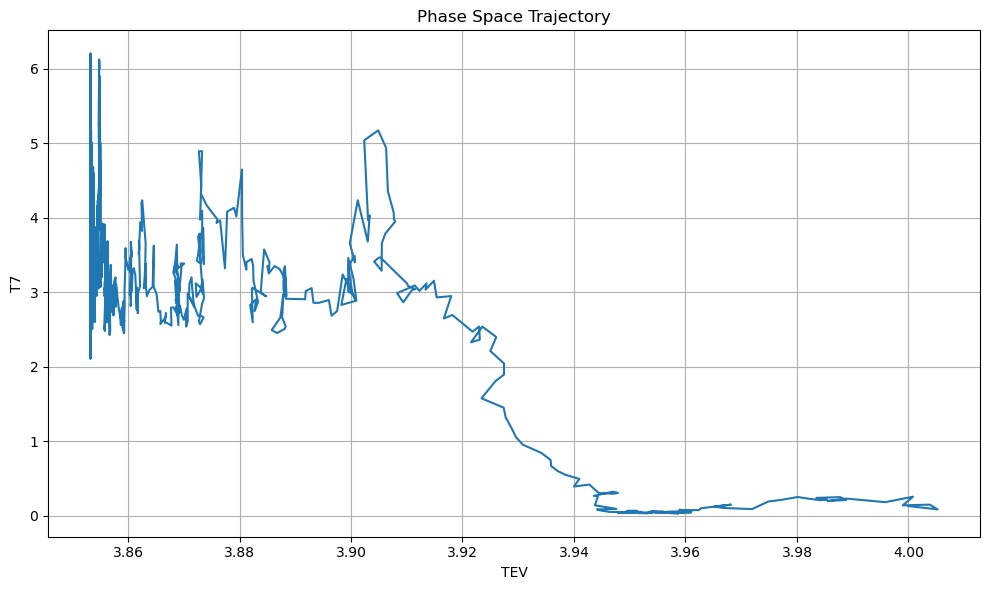

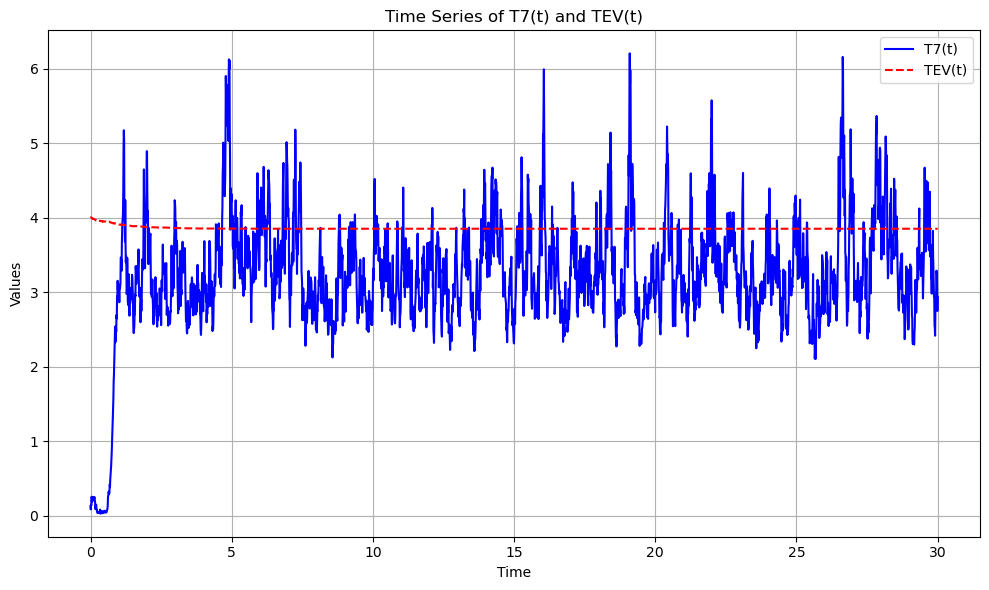

In [16]:
#Simulate with noise term
if __name__ == "__main__":
    initial_conditions = [0.13, 4.0]
    tspan = (0,30)

    t, X, r = euler_maruyama(tspan, initial_conditions)
    plot_phase_stochastic(t,X,r)
    plot_time_stochastic(t,X,r)

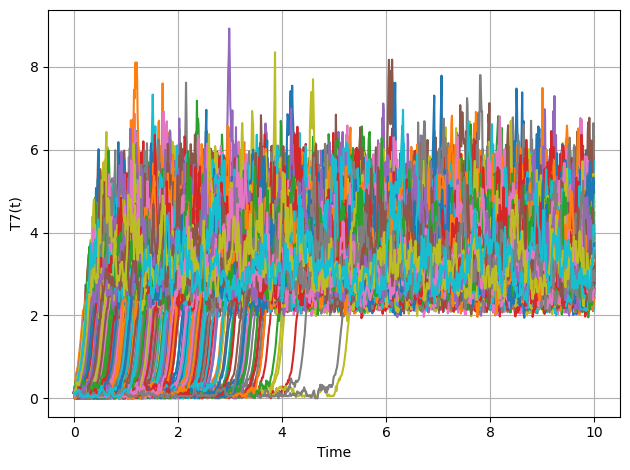

In [17]:
#Simulate ensemble
if __name__ == "__main__":
    # Initialize storage for t, X, r pairs
    results = []

    initial_conditions = [0.13, 4.0]
    tspan = (0, 10)

    for ix in range(1000):
        # Generate t, X, r using euler_maruyama
        t, X, r = euler_maruyama(tspan, initial_conditions)
        
        # Store the results in a list
        results.append((t, X, r))
        
        # Plot the trajectory
        plt.plot(t, X)

    plt.xlabel('Time')
    plt.ylabel("T7(t)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [18]:
def custom_pdf(tau, M, beta, tau_0):
    """Custom PDF function with parameters M (height), beta, and tau_0."""
    return np.where(tau > tau_0, M * (tau - tau_0 + 1) ** (-beta), 0)

def calculate_r2(y, y_fit):
    """Calculate R^2 value."""
    ss_res = np.sum((y - y_fit) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    return 1 - (ss_res / ss_tot)

if __name__ == "__main__":
    # Initialize storage for t, X pairs
    results = []

    initial_conditions = [0.13, 4.0]
    tspan = (0, 10)

    for ix in range(1000):
        # Generate t, X using euler_maruyama
        t, X, _ = euler_maruyama(tspan, initial_conditions)
        results.append((t, X))

    # Calculate first passage times
    fpt_list = []
    for t, X in results:
        # Find the first passage time where x >= 0
        fpt = next((t[i] for i, x in enumerate(X) if x >= 3), None)
        if fpt is not None:
            fpt_list.append(fpt)

    # Convert to numpy array for analysis
    fpt_array = np.array(fpt_list)

    # Create histogram
    bins = np.linspace(min(fpt_array), max(fpt_array), 50)
    hist, bin_edges = np.histogram(fpt_array, bins=bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Find initial guess for tau_0 (center of tallest bin) and M (maximum histogram value)
    tau_0_initial = bin_centers[np.argmax(hist)]
    M_initial = np.max(hist)
    


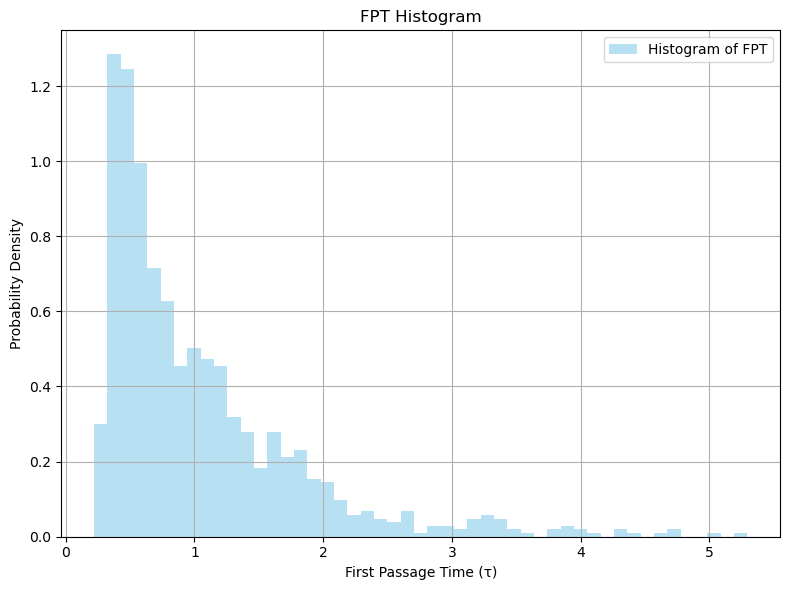

In [19]:
if __name__ == "__main__":
    # Find initial guess for tau_0 (center of tallest bin) and M (maximum histogram value)
    tau_0_initial = bin_centers[np.argmax(hist)]
    M_initial = np.max(hist)
    

    # Fit the custom PDF to the histogram data
    popt_custom, _ = curve_fit(
        custom_pdf, bin_centers, hist,
        p0=[M_initial, 1.0, tau_0_initial],  # Initial guess for [M, beta, tau_0]
        bounds=([0, 0, 0], [np.inf, np.inf, np.inf])  # Parameter bounds
    )
    M_custom, beta_custom, tau_0_custom = popt_custom
    custom_fit = custom_pdf(bin_centers, M_custom, beta_custom, tau_0_custom)
    r2_custom = calculate_r2(hist, custom_fit)

    # Plot the histogram of FPT values
    plt.figure(figsize=(8, 6))
    plt.hist(fpt_array, bins=bins, density=True, alpha=0.6, color="skyblue", label="Histogram of FPT")

    # Overlay fitted custom PDF
    tau_fit = np.linspace(min(bin_centers), max(bin_centers), 500)
    '''plt.plot(
        tau_fit,
        custom_pdf(tau_fit, M_custom, beta_custom, tau_0_custom),
        "r-", label=f"Custom Fit\n$M={M_custom:.2f}$, $\\beta={beta_custom:.2f}$, $\\tau_0={tau_0_custom:.2f}$, $R^2={r2_custom:.2f}$"
    )'''

    # Add labels, legend, and grid
    plt.xlabel("First Passage Time (τ)")
    plt.ylabel("Probability Density")
    plt.title("FPT Histogram")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

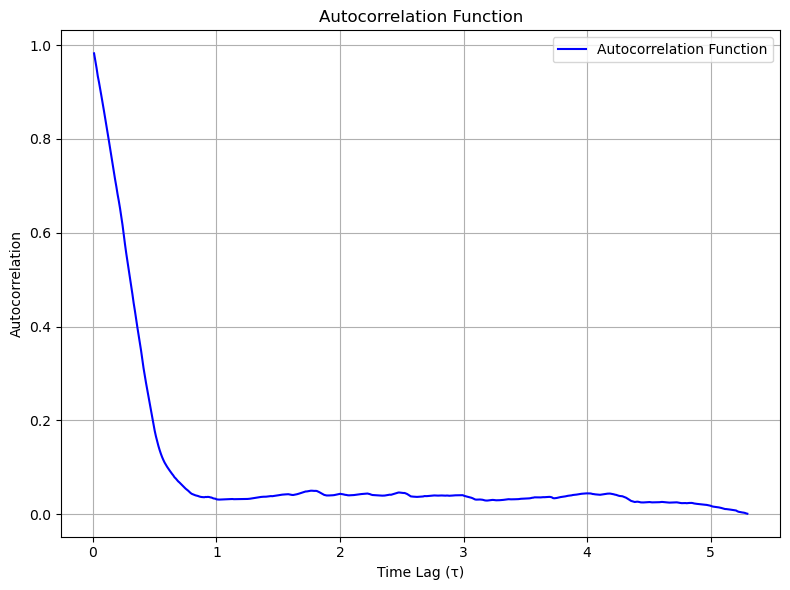

In [20]:
# Define the fitting function: C_x(tau) = A * (tau + 1)^(-beta)
def fit_function(tau, A, beta):
    return A * (tau + 1) ** (-beta)

def autocorrelation(x):
    """Calculate the autocorrelation function of the signal x."""
    n = len(x)
    result = np.correlate(x, x, mode='full')
    result = result[n - 1:]  # Keep only the second half of the result
    result /= np.max(result)  # Normalize to maximum value
    return result

if __name__ == "__main__":
    # Find the trial with the latest first passage time
    latest_fpt_index = np.argmax(fpt_list)
    latest_t, latest_X = results[latest_fpt_index]

    # Find the first passage time for the latest trial
    latest_fpt = fpt_list[latest_fpt_index]

    # Extract the position values up to the first passage time
    # Find the index where the first passage time occurs
    first_passage_index = np.where(latest_t >= latest_fpt)[0][0]  # Index of the first passage time

    # Extract position values up to the first passage time
    X_before_fpt = latest_X[:first_passage_index + 1]
    t_before_fpt = latest_t[:first_passage_index + 1]  # Time values up to the first passage time

    # Calculate the autocorrelation function for the extracted position data
    acf = autocorrelation(X_before_fpt)

    # Calculate the corresponding time lags for the autocorrelation
    time_lags = t_before_fpt - t_before_fpt[0]  # Subtract the initial time to get the lag

    # Fit the autocorrelation data to the model C_x(tau) = A * (tau + 1)^(-beta)
    popt, _ = curve_fit(fit_function, time_lags[1:], acf[1:], p0=[1, 1])  # Initial guess for A and beta
    A_fit, beta_fit = popt

    # Generate the fitted curve
    tau_fit = np.linspace(min(time_lags), max(time_lags), 500)
    acf_fit = fit_function(tau_fit, A_fit, beta_fit)

    # Plot the autocorrelation function with the fitted curve
    plt.figure(figsize=(8, 6))
    plt.plot(time_lags[1:], acf[1:], label="Autocorrelation Function", color='b')
    #plt.plot(tau_fit, acf_fit, 'r-', label=f"Fitted Curve\n$A={A_fit:.2f}$, $\\beta={beta_fit:.2f}$")
    plt.xlabel("Time Lag (τ)")
    plt.ylabel("Autocorrelation")
    plt.title("Autocorrelation Function")# and Fit to $C_x(\\tau) = A(\\tau + 1)^{-\\beta}$")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


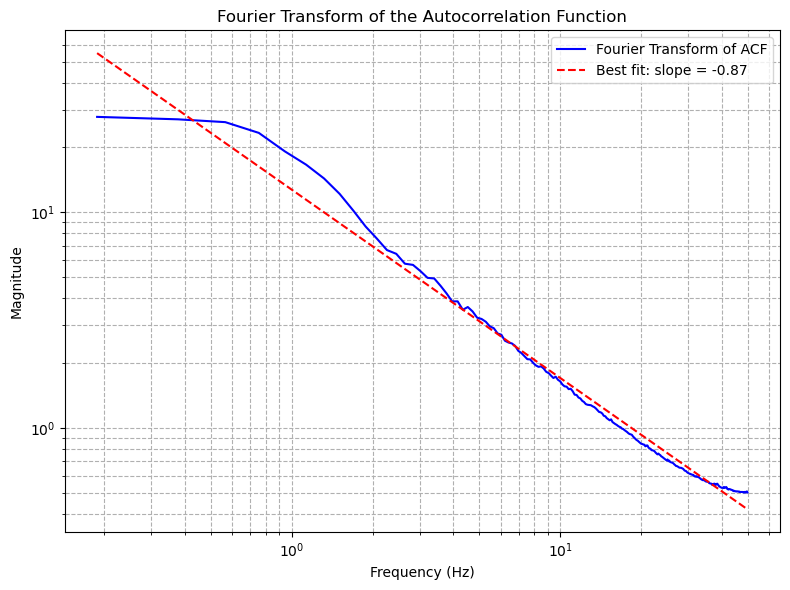

In [21]:
def fourier_transform(acf, dt):
    """Calculate the Fourier transform of the autocorrelation function and convert frequency to Hz."""
    # Perform Fourier transform on the autocorrelation function
    fft_result = np.fft.fft(acf)
    
    # Get the frequency values corresponding to the FFT result
    freq = np.fft.fftfreq(len(acf), d=dt)  # Use time step as spacing
    freq = np.fft.fftshift(freq)  # Shift zero frequency to the center
    fft_result = np.fft.fftshift(fft_result)  # Shift the FFT result to match the frequency shift
    
    # Return the magnitude of the Fourier transform and the frequencies in Hz
    return freq, np.abs(fft_result)

# Assuming `acf` has already been calculated and `dt` is the time step size
dt = t_before_fpt[1] - t_before_fpt[0]  # Calculate the time step size from the `t` array

# Calculate the Fourier transform of the autocorrelation function
freq, fft_magnitude = fourier_transform(acf, dt)

# Select positive frequencies for plotting
positive_freq_indices = freq > 0  # Only select positive frequencies

# Extract positive frequency and magnitude values
freq_pos = freq[positive_freq_indices]
fft_magnitude_pos = fft_magnitude[positive_freq_indices]

# Log-transform the frequency and magnitude values for fitting
log_freq = np.log10(freq_pos)
log_magnitude = np.log10(fft_magnitude_pos)

# Perform linear regression to get the best-fit line in log-log space
slope, intercept, r_value, p_value, std_err = linregress(log_freq, log_magnitude)

# Create the best-fit line
best_fit_line = 10**(intercept + slope * log_freq)

# Plot the Fourier transform (magnitude of the FFT) on a log-log scale
plt.figure(figsize=(8, 6))
plt.loglog(freq_pos, fft_magnitude_pos, label="Fourier Transform of ACF", color='b')
plt.loglog(freq_pos, best_fit_line, label=f"Best fit: slope = {slope:.2f}", color='r', linestyle='--')

# Labels and title
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Fourier Transform of the Autocorrelation Function")
plt.grid(True, which="both", ls="--")
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()
